In [ ]:
# !kaggle datasets download -d blastchar/telco-customer-churn

In [17]:
import pandas as pd
import numpy as np
import xgboost as xgb
import os
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

In [12]:
df = pd.read_csv('Telco-Customer-Churn.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [13]:
df.sample(10)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
65,5122-CYFXA,Female,0,No,No,3,Yes,No,DSL,No,...,No,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,75.30,244.1,No
320,5020-ZSTTY,Female,1,No,No,54,Yes,Yes,DSL,Yes,...,No,Yes,Yes,Yes,One year,No,Bank transfer (automatic),82.45,4350.1,Yes
5758,5847-MXBEO,Male,0,No,No,22,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,20.30,475.1,No
6224,2330-PQGDQ,Male,0,Yes,Yes,51,Yes,Yes,Fiber optic,No,...,No,Yes,No,No,One year,No,Bank transfer (automatic),84.20,4299.75,No
451,5760-WRAHC,Female,1,No,No,22,Yes,No,DSL,Yes,...,Yes,Yes,No,Yes,Month-to-month,Yes,Mailed check,69.75,1545.4,No
5119,6034-YMTOB,Female,0,No,No,5,Yes,No,Fiber optic,No,...,No,Yes,No,No,Month-to-month,Yes,Mailed check,75.65,399.45,No
1296,6729-GDNGC,Female,1,No,No,20,Yes,No,Fiber optic,No,...,No,No,Yes,No,Month-to-month,No,Bank transfer (automatic),80.70,1614.2,No
4220,4644-OBGFZ,Male,0,Yes,Yes,55,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,19.50,1026.35,No
6843,9940-HPQPG,Female,0,Yes,No,9,Yes,Yes,Fiber optic,Yes,...,Yes,No,No,No,Month-to-month,No,Bank transfer (automatic),91.75,865.8,Yes
1768,3055-VTCGS,Female,0,No,No,63,Yes,No,DSL,No,...,Yes,No,No,Yes,One year,No,Credit card (automatic),58.55,3503.5,No


<AxesSubplot:>

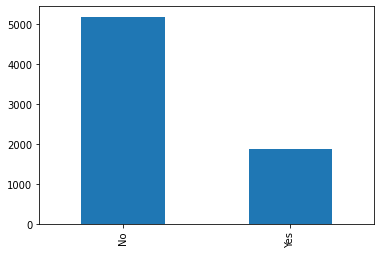

In [21]:
df.Churn.value_counts().plot(kind='bar')

<AxesSubplot:xlabel='gender'>

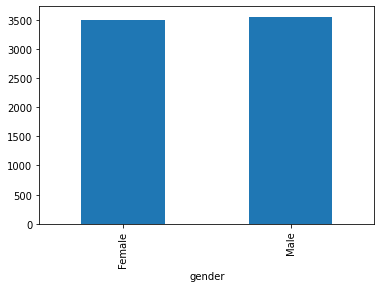

In [24]:
df.groupby('gender')['Churn'].count().plot(kind='bar')

In [26]:
df.PhoneService.value_counts()

Yes    6361
No      682
Name: PhoneService, dtype: int64

In [37]:
df.loc[(df.TotalCharges == ' ', 'TotalCharges')] = '0'

In [39]:
df[df.TotalCharges == '0']

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,0,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,0,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,0,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,0,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,0,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,0,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,0,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,0,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,0,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,0,No


In [43]:
df.TotalCharges = pd.to_numeric(df.TotalCharges)

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [45]:
df.replace(' ', '_', regex=True, inplace=True)
df.sample(10)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
2793,3904-UKFRE,Male,0,No,No,4,Yes,Yes,Fiber_optic,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic_check,80.10,336.15,No
5514,0623-GDISB,Female,0,No,No,1,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Bank_transfer_(automatic),48.45,48.45,No
1787,7789-HKSBS,Female,1,Yes,No,42,Yes,Yes,Fiber_optic,Yes,...,Yes,No,Yes,Yes,One_year,Yes,Bank_transfer_(automatic),105.20,4599.15,No
6627,1074-WVEVG,Female,0,Yes,No,59,Yes,No,No,No_internet_service,...,No_internet_service,No_internet_service,No_internet_service,No_internet_service,One_year,No,Mailed_check,20.35,1267.00,No
3989,7634-WSWDB,Female,0,No,Yes,8,No,No_phone_service,DSL,Yes,...,No,No,No,Yes,Month-to-month,Yes,Electronic_check,38.50,330.80,No
2067,4832-VRBMR,Male,1,Yes,No,65,Yes,Yes,Fiber_optic,No,...,Yes,No,Yes,Yes,One_year,Yes,Bank_transfer_(automatic),103.15,6792.45,No
5174,0947-IDHRQ,Female,0,No,No,7,Yes,No,Fiber_optic,No,...,No,No,Yes,No,Month-to-month,Yes,Mailed_check,80.30,526.70,Yes
6648,2164-SOQXL,Female,0,Yes,Yes,20,Yes,No,No,No_internet_service,...,No_internet_service,No_internet_service,No_internet_service,No_internet_service,Month-to-month,No,Mailed_check,20.05,406.05,No
3885,4090-KPJIP,Female,0,No,No,3,Yes,Yes,Fiber_optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic_check,74.95,212.40,No
6846,6618-RYATB,Female,0,No,No,1,Yes,Yes,Fiber_optic,No,...,Yes,No,No,No,Month-to-month,Yes,Mailed_check,79.55,79.55,Yes


In [59]:
X = df.drop(['customerID', 'Churn'], axis=1).copy()
y = df.Churn.copy()
X.shape, y.shape

((7043, 19), (7043,))

In [60]:
X.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
dtype: object

In [61]:
X_encoded = pd.get_dummies(X, columns=['gender',
                                       'SeniorCitizen',
                                       'Partner',
                                       'Dependents',
                                       'PhoneService',
                                       'MultipleLines',
                                       'InternetService',
                                       'OnlineSecurity',
                                       'OnlineBackup',
                                       'DeviceProtection',
                                       'TechSupport',
                                       'StreamingTV',
                                       'StreamingMovies',
                                       'Contract',
                                       'PaperlessBilling',
                                       'PaymentMethod',
                                      ])
X_encoded.sample(10)

,tenure,MonthlyCharges,TotalCharges,gender_Female,gender_Male,SeniorCitizen_0,SeniorCitizen_1,Partner_No,Partner_Yes,Dependents_No,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One_year,Contract_Two_year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank_transfer_(automatic),PaymentMethod_Credit_card_(automatic),PaymentMethod_Electronic_check,PaymentMethod_Mailed_check
2459,8,20.45,162.30,0,1,1,0,1,0,1,...,0,1,0,0,0,1,0,1,0,0
5331,44,54.05,2375.20,0,1,1,0,0,1,0,...,1,0,0,1,0,1,0,1,0,0
5438,9,79.90,741.70,0,1,1,0,0,1,1,...,0,1,0,0,0,1,0,0,1,0
2768,12,19.70,260.90,1,0,1,0,1,0,1,...,0,0,1,0,1,0,0,0,0,1
7029,6,44.40,263.05,1,0,0,1,1,0,1,...,1,1,0,0,0,1,0,0,1,0
2588,8,49.40,408.25,1,0,1,0,1,0,1,...,0,1,0,0,1,0,0,0,1,0
6048,29,94.45,2653.65,0,1,0,1,0,1,1,...,1,1,0,0,0,1,0,0,1,0
4846,7,69.15,488.65,0,1,1,0,1,0,1,...,0,1,0,0,1,0,1,0,0,0
5846,3,76.10,257.60,1,0,1,0,1,0,1,...,0,1,0,0,1,0,0,0,1,0
5945,57,95.30,5567.45,1,0,0,1,0,1,0,...,0,1,0,0,0,1,0,1,0,0


In [62]:
y.unique()

array(['No', 'Yes'], dtype=object)